In [6]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create Spark session
spark = SparkSession.builder.appName("weather-delay-analysis")\
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.0')\
    .getOrCreate()

# Define schema for weather data
weather_schema = StructType([
    StructField("time", TimestampType(), True),
    StructField("temperature_2m", DoubleType(), True),
    StructField("rain", DoubleType(), True),
    StructField("snowfall", DoubleType(), True),
    StructField("weather_code", StringType(), True)
])

# Load weather data
weather_df = spark.read.csv("data/open-meteo.csv",
                            schema=weather_schema,
                            header=True,
                            dateFormat="yyyy-MM-dd'T'HH:mm")

# Load departures data
departures_df = spark.read.parquet("data/filtered_01.parquet")

# Join weather and departures data
merged_df = departures_df.join(weather_df, departures_df['when'] == weather_df['time'], "inner")


In [7]:
# Perform some basic analysis
print("Correlation between weather factors and delay:")
for col in ["temperature_2m", "rain", "snowfall"]:
    correlation = merged_df.stat.corr("delay", col)
    print(f"Correlation between delay and {col}: {correlation}")

Correlation between weather factors and delay:


24/09/23 15:08:51 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: time, temperature_2m (°C)
 Schema: time, temperature_2m
Expected: temperature_2m but found: temperature_2m (°C)
CSV file: file:///usr/local/spark/notebooks/data/open-meteo.csv


Correlation between delay and temperature_2m: -0.024552255810987116


24/09/23 15:08:55 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: time, rain (mm)
 Schema: time, rain
Expected: rain but found: rain (mm)
CSV file: file:///usr/local/spark/notebooks/data/open-meteo.csv
24/09/23 15:08:57 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: time, snowfall (cm)
 Schema: time, snowfall
Expected: snowfall but found: snowfall (cm)
CSV file: file:///usr/local/spark/notebooks/data/open-meteo.csv


Correlation between delay and rain: 0.004165149512058696
Correlation between delay and snowfall: nan


24/09/23 15:11:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: time, temperature_2m (°C)
 Schema: time, temperature_2m
Expected: temperature_2m but found: temperature_2m (°C)
CSV file: file:///usr/local/spark/notebooks/data/open-meteo.csv


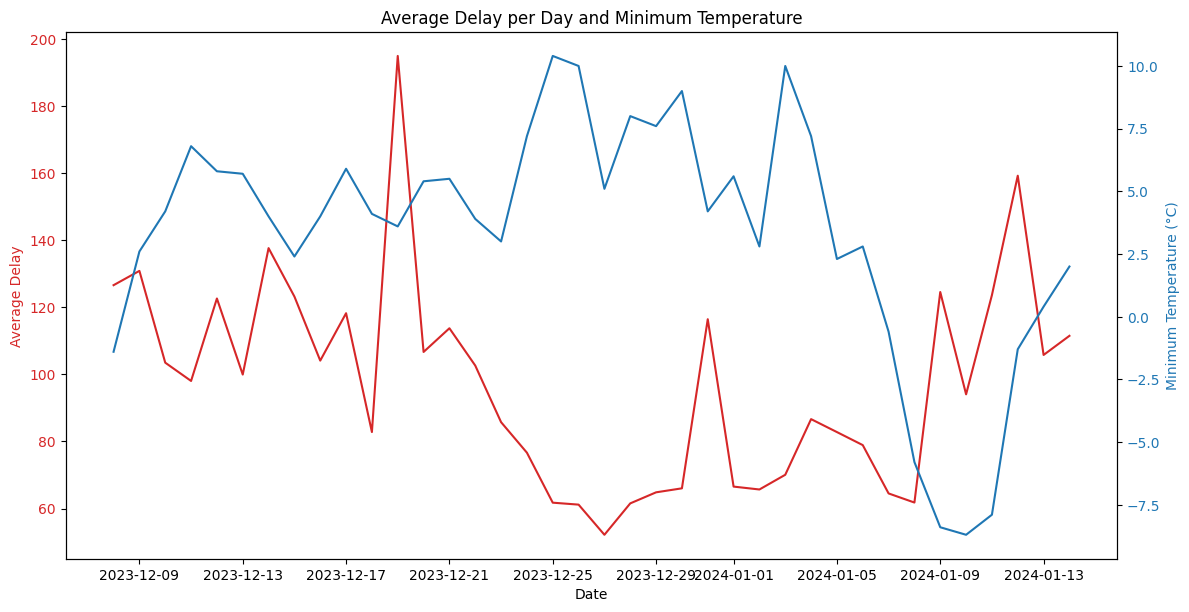

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Aggregate data to get average delay and minimum temperature per day
daily_stats_df = merged_df.withColumn('date', F.to_date('time')) \
    .groupBy('date') \
    .agg(
        F.avg('delay').alias('avg_delay'),
        F.min('temperature_2m').alias('min_temp')
    )

# Collect data to a Pandas DataFrame
daily_stats_pd = daily_stats_df.orderBy('date').toPandas()

# Plotting
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Average Delay', color='tab:red')
ax1.plot(daily_stats_pd['date'], daily_stats_pd['avg_delay'], color='tab:red', label='Average Delay')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Minimum Temperature (°C)', color='tab:blue')
ax2.plot(daily_stats_pd['date'], daily_stats_pd['min_temp'], color='tab:blue', label='Minimum Temperature')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.title('Average Delay per Day and Minimum Temperature')
plt.show()


In [4]:
# Prepare data for machine learning
feature_cols = ["temperature_2m", "rain", "snowfall"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
ml_data = assembler.transform(merged_df.select("delay", *feature_cols))

# Handle potential null values
ml_data = ml_data.na.drop(subset=["features", "delay"])

# Split the data
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

# Train a linear regression model
lr = LinearRegression(featuresCol="features", labelCol="delay")
model = lr.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="delay", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error: {rmse}")

# Show feature coefficients
coefficients = model.coefficients
for feature, coef in zip(feature_cols, coefficients):
    print(f"{feature}: {coef}")

# Optional: Save results or model for further analysis
# predictions.write.parquet("path/to/predictions.parquet")
# model.save("path/to/model")

# Stop Spark session
spark.stop()

24/09/23 15:04:55 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: time, temperature_2m (°C), rain (mm), snowfall (cm)
 Schema: time, temperature_2m, rain, snowfall
Expected: temperature_2m but found: temperature_2m (°C)
CSV file: file:///usr/local/spark/notebooks/data/open-meteo.csv
24/09/23 15:04:56 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: time, temperature_2m (°C), rain (mm), snowfall (cm)
 Schema: time, temperature_2m, rain, snowfall
Expected: temperature_2m but found: temperature_2m (°C)
CSV file: file:///usr/local/spark/notebooks/data/open-meteo.csv
24/09/23 15:04:56 WARN Instrumentation: [82fe2eef] regParam is zero, which might cause numerical instability and overfitting.
24/09/23 15:05:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/23 15:05:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/09/

Root Mean Squared Error: 335.9576718018939
temperature_2m: -2.043069130832924
rain: 8.611886491299403
snowfall: 0.0
